# TSAI SS2025 Exercise Sheet 9 - Template Code

In [3]:
# import os
# os.environ["OMP_NUM_THREADS"] = "4" # limit numpy threads if needed.
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

## The Reparameterization Trick in Variational Inference

### Gradient issue

Consider
$$ \nabla_{\phi} E_{q_{\phi}(z|x)}(\log p_{\phi}(x|z)) = \nabla_{\phi} \int \log p_{\phi}(x|z) q_{\phi}(z|x) dz$$
We assume the conditions for the interchangability of the derivative and the integral are satisfied and write
$$  \nabla_{\phi} \int \log p_{\phi}(x|z) q_{\phi}(z|x) dz =  \int \nabla_{\phi} (\log p_{\phi}(x|z) q_{\phi}(z|x)) dz$$
Using the product rule
$$ \int \nabla_{\phi}(\log p_{\phi}(x|z) q_{\phi}(z|x)) dz = \int \nabla_{\phi}(\log p_{\phi}(x|z)) q_{\phi}(z|x) dz + \int \log p_{\phi}(x|z) \nabla_{\phi}(q_{\phi}(z|x)) dz $$
The problem is that we cannot compute (or have difficulty computing) the value $ \nabla_{\phi}(\log p_{\phi}(x|z))$, $\mu_{\phi}(x)$ and $\sigma_{\phi}(x)$ determining the density are outputted from the neural network. Therefore it is difficult to compute the gradiant (https://gregorygundersen.com/blog/2018/04/29/reparameterization/). 

This poses a challenge to gradient-based optimization because this relies on being able to compute gradients and often. 

### Derivation of the reparameterization trick

Using the definition of $q_{\phi}(z|x)$
$$  E_{q_{\phi}(z|x)}(\log p_{\phi}(x|z)) =  \int \log p_{\phi}(x|z) \frac{1}{\sqrt{2 \pi \sigma_{\phi}(x)^2}} \exp(- \frac{(z - \mu_{\phi}(x))^2}{2 \sigma_\phi(x)^2}) dz$$
Note that
$$ \epsilon = \frac{z - \mu_\phi(x)}{\sigma_{\phi}(x)}$$
Where the division again is element wise. Thus
$$ \int \log p_{\phi}(x|z) \frac{1}{\sqrt{2 \pi \sigma_{\phi}(x)^2}} \exp(- \frac{(z - \mu_{\phi}(x))^2}{2 \sigma_\phi(x)^2}) dz = \int \log p_{\phi}(x|z(\epsilon, \phi)) \frac{1}{\sqrt{2 \pi \sigma_{\phi}(x)^2}} \exp(- \frac{\epsilon^2}{2}) dz$$
Note too: $ \frac{d\epsilon}{dz} = \frac{1}{\sigma_{\phi}(x)}$, letting us perform the substitution of the integration variable
$$\int \log p_{\phi}(x|z(\epsilon, \phi)) \frac{1}{\sqrt{2 \pi \sigma_{\phi}(x)^2}} \exp(- \frac{\epsilon^2}{2}) dz = \int \log p_{\phi}(x|z(\epsilon, \phi)) \frac{1}{\sqrt{2 \pi}} \exp(- \frac{\epsilon^2}{2}) d\epsilon = E_{\epsilon \sim \mathcal{N}(0,I)} ( \log p_{\phi}(x|z(\epsilon, \phi)))$$


Using the chain rule, we can find the gradient by
$$ \nabla_{\phi} E_{\epsilon \sim \mathcal{N}(0,I)}(\log p_{\phi}(x|z)) = \nabla_{\phi} \int \log p_{\phi}(x|z(\epsilon, \phi)) \frac{1}{\sqrt{2 \pi}} \exp(- \frac{\epsilon^2}{2}) d\epsilon$$
$$ = \int  \nabla_{\phi} (\log p_{\phi}(x|z(\epsilon, \phi))) \frac{1}{\sqrt{2 \pi}} \exp(- \frac{\epsilon^2}{2}) d\epsilon$$
$$ = \int \frac{1}{p_{\phi}(x|z(\epsilon, \phi))}\left(\frac{\partial}{\partial\phi} p_{\phi}(x|z(\epsilon, \phi))\right) \frac{1}{\sqrt{2 \pi}} \exp(- \frac{\epsilon^2}{2}) d\epsilon$$
$$ = E_{\epsilon \sim \mathcal{N}(0,I)} \left(\frac{1}{p_{\phi}(x|z(\epsilon, \phi))}\left(\frac{\partial}{\partial\phi} p_{\phi}(x|z(\epsilon, \phi))\right)\right)$$

### Extension to sequential latent variables

We now want to compute the gradient of
$$\nabla_{\phi} E_{q_{\phi}(z_{1:T}|x_{1:T})}(\log p_{\phi}(x_{1:T}|z_{1:T}))$$
Due to independence assumptions we can write the distributions of the $z$'s as
$$q_{\phi}(z_{1:T}|x_{1:T}) = \prod_{t=1}^T q_{\phi}(z_{t}|x_{1:t})$$


This gives us the opportunity to use the reparametrization trick at each time step. We can do $z_t = \mu_{\phi}(x_{1:t}) + \sigma_{\phi}(x_{1:t}) \odot \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0,1)$ for all $t=1,...,T$. Where $\mu_{\phi}(x_{1:t})$ and $\sigma_{\phi}(x_{1:t})$ are outputs from a RNN with parameters $\phi$. 

## Reservoir computing

### In the template code, implement all necessary functions to train and generate from an ESN

In [71]:
class ESN:
    def __init__(self, N, M, alpha, beta, sigma, rho):
        # observation space dimensionality
        self.N = N
        # reservoir size
        self.M = M
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.rho = rho

        # draw W_in from Gaussian distribution with mean 0 and variance sigma^2
        self.W_in = np.random.randn(self.M, self.N) * self.sigma

        # draw b from Gaussian distribution with mean 0 and variance beta^2
        self.b = np.random.randn(self.M) * self.beta

        # draw W randomly and renormalize to have spectral radius rho
        W = np.random.randn(self.M, self.M)
        self.W = W / np.max(np.abs(np.linalg.eigvals(W))) * self.rho

        # output weights (will be overwritten by training)
        self.W_out = None

    def forward(self, x, r):
        """Forward pass of the ESN. Implements the state equation.

        Args:
            x (np.ndarray): Input data (1D array, N)
            r (np.ndarray): Reservoir state (1D array, M)

        Returns:
            np.ndarray: Next reservoir state (1D array, M)
        """
        r_t_1 = (1- self.alpha) * r + self.alpha * np.tanh(self.W @ r + self.W_in @ x + self.b)
        return r_t_1

    def __call__(self, x, r):
        return self.forward(x, r)

    def drive(self, X):
        """Drive the ESN with input X.

        Args:
            X (np.ndarray): Input data (2D array, T x N)

        Returns:
            np.ndarray: Reservoir states (2D array, T x M)
        """
        T = X.shape[0]
        R = np.zeros((T, self.M))
        R[0, :] = self.forward(X[0, :], np.zeros(self.M))
        for t in range(1,T):
            R[t,:] = self.forward(X[t,:], R[(t-1),:])
        return R


    def train(self, X, Y, ridge_lambda, t_trans=1000):
        """Compute the output weights using ridge regression. Store the output weights in self.W_out.

        Args:
            X (np.ndarray): Input data (2D array, T x N)
            Y (np.ndarray): Target data (2D array, T x N)
            ridge_lambda (float): Ridge regression parameter
            t_trans (int, optional): Number of transient steps to discard.

        Returns:
            float: Training error
        """
        # drive the ESN with input X
        R = self.drive(X)

        # discard transient steps
        R_ = R[t_trans:, :]
        Y_ = Y[t_trans:, :]

        # compute the output weights using ridge regression -> (N x M) output weights
        self.W_out = Y_.T @ R_ @ np.linalg.inv(R_.T @ R_+ ridge_lambda * np.identity(self.M)) 

        # compute the training error using fittet W_out
        L_RR = np.linalg.norm(Y_- R_ @ self.W_out.T, 'fro') ** 2 + ridge_lambda * np.linalg.norm(self.W_out, 'fro') ** 2
        return L_RR

    def generate(self, X, T_gen):
        """Generate data from the ESN.

        Args:
            X (np.ndarray): Input data (2D array, T x N)
            T_gen (int): Number of steps to generate

        Returns:
            np.ndarray: Generated data in the observation space (2D array, T_gen x N)
        """
        # Run the warm up
        R_warm_up = self.drive(X)

        # Define the new W and an array to store the results
        W_new = self.W + self.W_in @ self.W_out
        R = np.zeros((T_gen, self.M))

        # Initialize 
        R[0,:] = self.forward(X[-1,:], R_warm_up[-1,:])

        # Predict using the previous model prediction
        for t in range(1, T_gen):
            R[t,:] = (1 - self.alpha) * R[(t-1),:] + self.alpha * np.tanh(W_new @ R[(t-1),:] + self.b)

        return  R @ self.W_out.T


1.2 Train and generate data, validate the model

In [72]:
data = np.load("lorenz_data.npy")
print(data.shape)

T_train = 10000 # use first 10000 data points for training

# split data into input (driving) and target data
X = data[:T_train, :]
Y = data[1 : T_train + 1, :]

(20000, 3)


### Train and fit the ESN with the specified hyperparameters. Generate a trajectory from the model and plot 3D state space.

In [81]:
# hypers
N = 3
M = 500
alpha = 0.6
beta = 0.7
sigma = 0.3
rho = 0.75
ridge_lambda = 1e-2

In [82]:
# initialize ESN
esn = ESN(N, M, alpha, beta, sigma, rho)

# train ESN
loss = esn.train(X, Y, ridge_lambda) 
print(loss)

# generate data using trained ESN
X_drive = X[:1000, :]
X_gen = esn.generate(X_drive, data.shape[0])

26.184794670633384


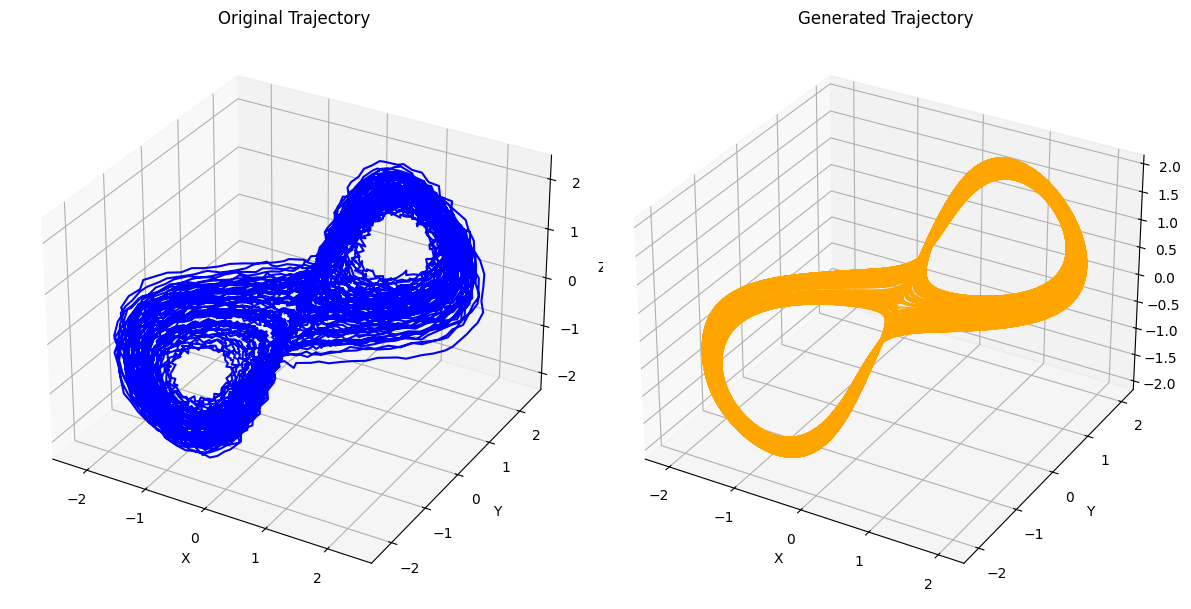

In [83]:
# plot trajectories of respective models (plot 3d, use subplots)
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

# Split into components
x1, y1, z1 = Y[:, 0], Y[:, 1], Y[:, 2]
x2, y2, z2 = X_gen[:, 0], X_gen[:, 1], X_gen[:, 2]

# Create figure with two 3D subplots
fig = plt.figure(figsize=(12, 6))

# --- Original Trajectory ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(x1, y1, z1, color='blue')
ax1.set_title("Original Trajectory")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# --- Generated Trajectory ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(x2, y2, z2, color='orange')
ax2.set_title("Generated Trajectory")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

plt.tight_layout()
plt.show()

It looks reasonable, although very much less messy. 

1.3 Line search across latent dimension

*How low can you go with the latent dimension? How robust is the training, i.e., how much do results differ between networks trained with different sampled reservoir network parameters? (Train five models per M.)*

In [33]:
# your code here